In [6]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

#need to be connected to vpn
# note, all server information is stored in a config.py file 
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

In [17]:
# Models/algorithms/classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation of models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.calibration import calibration_curve

# Text vectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
from sklearn.metrics import accuracy_score

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score


https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/firstday/first_day_sofa.sql - code for finding subsets of SOFA score

https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/score/sofa.sql
calculates hourly sofa score using derived tables in mimic_derived on BigQuery

Also https://github.com/MIT-LCP/critical-data-book/blob/master/part_ii/chapter_10/SQL_query_cohort_selection.sql for labs etc


In [79]:
labs = pd.read_csv("first_day_basic_labs_9700_2-23-22.csv") 
#ran in biquery for first 10000 cases and exported here as csv
labs.head()

,subject_id,stay_id,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,abs_basophils_min,abs_basophils_max,abs_eosinophils_min,abs_eosinophils_max,abs_lymphocytes_min,abs_lymphocytes_max,abs_monocytes_min,abs_monocytes_max,abs_neutrophils_min,abs_neutrophils_max,atyps_min,atyps_max,bands_min,bands_max,imm_granulocytes_min,imm_granulocytes_max,metas_min,metas_max,nrbc_min,nrbc_max,d_dimer_min,d_dimer_max,fibrinogen_min,fibrinogen_max,thrombin_min,thrombin_max,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max
0,12776735,34547665,30.6,30.6,10.0,10.0,157.0,157.0,7.8,7.8,3.9,3.9,NaN,NaN,NaN,NaN,13.0,13.0,22.0,22.0,8.0,8.0,8.2,8.2,97.0,97.0,1.0,1.0,113.0,113.0,129.0,130.0,3.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,1.6,17.3,17.3,44.1,44.1
1,16256226,39289362,30.5,30.5,10.0,10.0,209.0,209.0,3.5,3.5,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,21.0,21.0,9.0,9.0,8.1,8.1,108.0,108.0,0.5,0.5,99.0,99.0,141.0,141.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.1,11.8,11.8,32.4,32.4
2,12974563,32563675,41.6,41.6,13.7,13.7,184.0,184.0,10.6,10.6,NaN,NaN,NaN,NaN,NaN,NaN,23.0,23.0,16.0,16.0,23.0,23.0,8.9,8.9,104.0,104.0,1.0,1.0,78.0,78.0,139.0,139.0,4.4,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,0.9,10.2,10.2,20.5,20.5
3,14609218,34947848,36.0,37.7,11.8,12.2,250.0,267.0,10.2,12.1,3.9,3.9,NaN,NaN,NaN,NaN,18.0,18.0,22.0,23.0,8.0,9.0,9.2,9.2,98.0,98.0,0.5,0.6,106.0,136.0,134.0,134.0,4.1,4.6,0.04,0.04,0.0,0.0,0.93,0.93,0.39,0.39,8.77,8.77,NaN,NaN,NaN,NaN,0.8,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.1,12.2,12.4,28.6,29.3
4,12687112,37445058,30.0,30.0,9.8,9.8,176.0,176.0,5.4,5.4,NaN,NaN,NaN,NaN,NaN,NaN,19.0,19.0,19.0,19.0,62.0,62.0,8.4,8.4,105.0,105.0,8.2,8.2,127.0,127.0,143.0,143.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,10.3,10.3,21.1,21.1


In [82]:
labs.shape

(9710, 66)

In [5]:
dispo = pd.read_csv("discharge_disposition_clean2-20-22.csv")
dispo.head()

,Unnamed: 0,hadm_id,admittime,dischtime,deathtime,hospital_expire_flag,admission_location,discharge_location
0,0,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaN,0,NaN,Home
1,1,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaN,0,NaN,Home
2,2,21965160,2147-01-14 09:00:00,2147-01-17 14:25:00,NaN,0,NaN,Home
3,3,24709883,2165-12-27 17:33:00,2165-12-31 21:18:00,NaN,0,NaN,Home
4,4,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaN,0,NaN,Home


In [9]:
death = dispo[['hadm_id','hospital_expire_flag']]
death.head()

,hadm_id,hospital_expire_flag
0,21038362,0
1,24941086,0
2,21965160,0
3,24709883,0
4,23272159,0


In [10]:
death.hospital_expire_flag.value_counts()

0    514390
1      9350
Name: hospital_expire_flag, dtype: int64

In [8]:
#link hadm_id and stay_id - is this in icustays?

sql = query_schema + """
select hadm_id, stay_id
from mimiciv.icustays
"""
admstay = pd.read_sql_query(sql,conn) 
admstay


,hadm_id,stay_id
0,24528534,31793211
1,28960964,31983544
2,27385897,33183475
3,23483021,34131444
4,20817525,34547665
...,...,...
76535,27299174,39990887
76536,28911582,39991872
76537,22562812,39992247
76538,24221219,39993265


In [12]:
death_id = pd.merge(admstay, death)
death_id.head()

,hadm_id,stay_id,hospital_expire_flag
0,24528534,31793211,0
1,28960964,31983544,0
2,27385897,33183475,1
3,23483021,34131444,0
4,20817525,34547665,0


In [83]:
death_id_labs = pd.merge(death_id, labs)
death_id_labs.head()

,hadm_id,stay_id,hospital_expire_flag,subject_id,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,abs_basophils_min,abs_basophils_max,abs_eosinophils_min,abs_eosinophils_max,abs_lymphocytes_min,abs_lymphocytes_max,abs_monocytes_min,abs_monocytes_max,abs_neutrophils_min,abs_neutrophils_max,atyps_min,atyps_max,bands_min,bands_max,imm_granulocytes_min,imm_granulocytes_max,metas_min,metas_max,nrbc_min,nrbc_max,d_dimer_min,d_dimer_max,fibrinogen_min,fibrinogen_max,thrombin_min,thrombin_max,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max
0,24528534,31793211,0,17867402,39.9,45.4,13.7,15.8,364.0,401.0,14.1,25.5,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,31.0,31.0,6.0,7.0,9.0,9.1,105.0,106.0,0.7,0.9,120.0,123.0,140.0,142.0,4.1,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.0,229.0,NaN,NaN,1.2,1.2,13.7,13.7,21.7,27.4
1,28960964,31983544,0,14435996,31.8,35.7,10.6,11.9,102.0,128.0,13.5,17.1,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,25.0,28.0,8.0,12.0,8.2,8.5,103.0,104.0,0.7,0.9,108.0,130.0,141.0,143.0,3.5,4.5,0.02,0.02,0.02,0.02,2.55,2.55,1.13,1.13,11.40,11.40,NaN,NaN,NaN,NaN,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,204.0,204.0,NaN,NaN,1.1,1.2,12.1,12.9,21.3,24.5
2,27385897,33183475,1,17609946,34.4,42.1,11.5,14.2,122.0,150.0,12.6,17.8,2.7,2.7,NaN,NaN,NaN,NaN,22.0,28.0,15.0,19.0,88.0,98.0,8.3,8.9,97.0,101.0,2.1,3.1,77.0,127.0,135.0,139.0,4.0,4.5,0.00,0.00,0.00,0.00,0.63,1.25,1.51,1.60,9.58,13.71,0.0,0.0,13.0,17.0,NaN,NaN,5.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.6,15.9,17.1,26.8,30.8
3,23483021,34131444,0,18966770,30.6,41.9,11.0,14.1,207.0,244.0,8.7,9.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.0,27.0,27.0,17.0,19.0,8.7,8.7,105.0,105.0,1.1,1.2,134.0,134.0,139.0,139.0,3.8,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.0,317.0,NaN,NaN,1.1,1.1,12.9,12.9,25.2,25.2
4,20817525,34547665,0,12776735,30.6,30.6,10.0,10.0,157.0,157.0,7.8,7.8,3.9,3.9,NaN,NaN,NaN,NaN,13.0,13.0,22.0,22.0,8.0,8.0,8.2,8.2,97.0,97.0,1.0,1.0,113.0,113.0,129.0,130.0,3.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,1.6,17.3,17.3,44.1,44.1


In [84]:
death_id_labs.shape

(9710, 68)

now, let's run a very simple xgboost model to see if first day's labs can predict mortality
based on https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/ tutorial


In [85]:
death_id_labs['hospital_expire_flag'] #outcome of interest, Y 

0       0
1       0
2       1
3       0
4       0
       ..
9705    0
9706    0
9707    0
9708    0
9709    0
Name: hospital_expire_flag, Length: 9710, dtype: int64

In [86]:
death_id_labs.iloc[:,2] #another way of selecting it 

0       0
1       0
2       1
3       0
4       0
       ..
9705    0
9706    0
9707    0
9708    0
9709    0
Name: hospital_expire_flag, Length: 9710, dtype: int64

In [87]:
death_id_labs.iloc[:,4:68] #put into the model, the predictors 

,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,abs_basophils_min,abs_basophils_max,abs_eosinophils_min,abs_eosinophils_max,abs_lymphocytes_min,abs_lymphocytes_max,abs_monocytes_min,abs_monocytes_max,abs_neutrophils_min,abs_neutrophils_max,atyps_min,atyps_max,bands_min,bands_max,imm_granulocytes_min,imm_granulocytes_max,metas_min,metas_max,nrbc_min,nrbc_max,d_dimer_min,d_dimer_max,fibrinogen_min,fibrinogen_max,thrombin_min,thrombin_max,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max
0,39.9,45.4,13.7,15.8,364.0,401.0,14.1,25.5,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,31.0,31.0,6.0,7.0,9.0,9.1,105.0,106.0,0.7,0.9,120.0,123.0,140.0,142.0,4.1,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.0,229.0,NaN,NaN,1.2,1.2,13.7,13.7,21.7,27.4
1,31.8,35.7,10.6,11.9,102.0,128.0,13.5,17.1,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,25.0,28.0,8.0,12.0,8.2,8.5,103.0,104.0,0.7,0.9,108.0,130.0,141.0,143.0,3.5,4.5,0.02,0.02,0.02,0.02,2.55,2.55,1.13,1.13,11.40,11.40,NaN,NaN,NaN,NaN,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,204.0,204.0,NaN,NaN,1.1,1.2,12.1,12.9,21.3,24.5
2,34.4,42.1,11.5,14.2,122.0,150.0,12.6,17.8,2.7,2.7,NaN,NaN,NaN,NaN,22.0,28.0,15.0,19.0,88.0,98.0,8.3,8.9,97.0,101.0,2.1,3.1,77.0,127.0,135.0,139.0,4.0,4.5,0.00,0.00,0.00,0.00,0.63,1.25,1.51,1.60,9.58,13.71,0.0,0.0,13.0,17.0,NaN,NaN,5.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.6,15.9,17.1,26.8,30.8
3,30.6,41.9,11.0,14.1,207.0,244.0,8.7,9.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.0,27.0,27.0,17.0,19.0,8.7,8.7,105.0,105.0,1.1,1.2,134.0,134.0,139.0,139.0,3.8,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.0,317.0,NaN,NaN,1.1,1.1,12.9,12.9,25.2,25.2
4,30.6,30.6,10.0,10.0,157.0,157.0,7.8,7.8,3.9,3.9,NaN,NaN,NaN,NaN,13.0,13.0,22.0,22.0,8.0,8.0,8.2,8.2,97.0,97.0,1.0,1.0,113.0,113.0,129.0,130.0,3.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,1.6,17.3,17.3,44.1,44.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9705,32.7,32.7,10.6,10.6,283.0,283.0,17.9,17.9,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,22.0,22.0,14.0,14.0,NaN,NaN,101.0,101.0,0.7,0.7,152.0,152.0,137.0,137.0,3.7,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9706,40.3,44.2,13.2,14.9,138.0,153.0,15.3,16.2,3.7,3.7,NaN,NaN,NaN,NaN,10.0,13.0,19.0,24.0,30.0,31.0,7.9,8.7,108.0,113.0,1.6,1.8,104.0,131.0,144.0,145.0,3.5,4.0,0.06,0.06,0.09,0.09,1.47,1.47,1.08,1.08,12.50,12.50,NaN,NaN,NaN,NaN,0.6,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,10.7,11.1,28.7,29.2
9707,34.8,34.8,11.7,11.7,123.0,123.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0,19.0,19.0,11.0,11.0,7.7,7.7,106.0,106.0,1.1,1.1,117.0,117.0,137.0,137.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,1.2,13.5,13.5,27.0,27.0
9708,35.2,35.2,11.5,11.5,247.0,247.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,21.0,21.0,9.0,9.0,8.4,8.4,112.0,112.0,0.6,0.6,103.0,103.0,143.0,143.0,3.8,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.1,12.4,12.4,24.6,24.6


In [88]:
X = death_id_labs.iloc[:,4:68]
Y = death_id_labs.iloc[:,2]

In [89]:
X.head()

,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,abs_basophils_min,abs_basophils_max,abs_eosinophils_min,abs_eosinophils_max,abs_lymphocytes_min,abs_lymphocytes_max,abs_monocytes_min,abs_monocytes_max,abs_neutrophils_min,abs_neutrophils_max,atyps_min,atyps_max,bands_min,bands_max,imm_granulocytes_min,imm_granulocytes_max,metas_min,metas_max,nrbc_min,nrbc_max,d_dimer_min,d_dimer_max,fibrinogen_min,fibrinogen_max,thrombin_min,thrombin_max,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max
0,39.9,45.4,13.7,15.8,364.0,401.0,14.1,25.5,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,31.0,31.0,6.0,7.0,9.0,9.1,105.0,106.0,0.7,0.9,120.0,123.0,140.0,142.0,4.1,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.0,229.0,NaN,NaN,1.2,1.2,13.7,13.7,21.7,27.4
1,31.8,35.7,10.6,11.9,102.0,128.0,13.5,17.1,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,25.0,28.0,8.0,12.0,8.2,8.5,103.0,104.0,0.7,0.9,108.0,130.0,141.0,143.0,3.5,4.5,0.02,0.02,0.02,0.02,2.55,2.55,1.13,1.13,11.40,11.40,NaN,NaN,NaN,NaN,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,204.0,204.0,NaN,NaN,1.1,1.2,12.1,12.9,21.3,24.5
2,34.4,42.1,11.5,14.2,122.0,150.0,12.6,17.8,2.7,2.7,NaN,NaN,NaN,NaN,22.0,28.0,15.0,19.0,88.0,98.0,8.3,8.9,97.0,101.0,2.1,3.1,77.0,127.0,135.0,139.0,4.0,4.5,0.00,0.00,0.00,0.00,0.63,1.25,1.51,1.60,9.58,13.71,0.0,0.0,13.0,17.0,NaN,NaN,5.0,6.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.6,15.9,17.1,26.8,30.8
3,30.6,41.9,11.0,14.1,207.0,244.0,8.7,9.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.0,27.0,27.0,17.0,19.0,8.7,8.7,105.0,105.0,1.1,1.2,134.0,134.0,139.0,139.0,3.8,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.0,317.0,NaN,NaN,1.1,1.1,12.9,12.9,25.2,25.2
4,30.6,30.6,10.0,10.0,157.0,157.0,7.8,7.8,3.9,3.9,NaN,NaN,NaN,NaN,13.0,13.0,22.0,22.0,8.0,8.0,8.2,8.2,97.0,97.0,1.0,1.0,113.0,113.0,129.0,130.0,3.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,1.6,17.3,17.3,44.1,44.1


In [90]:
Y.head()

0    0
1    0
2    1
3    0
4    0
Name: hospital_expire_flag, dtype: int64

In [91]:
# split data into train and test sets
seed = 7
test_size = 0.20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [92]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, Y_train)

/Users/catgaohow/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
#Okay, I don't really know what all these details mean but assume they are parameters that can be tuned


In [93]:
# make predictions for test data
Y_test_pred = model.predict(X_test)
Y_test_pred_round = [round(value) for value in Y_test_pred]

In [94]:
# evaluate predictions
accuracy = accuracy_score(Y_test, Y_test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.05%


In [95]:
# Predictions
Y_train_preds = model.predict_proba(X_train)[:,1]
Y_test_preds = model.predict_proba(X_test)[:,1]

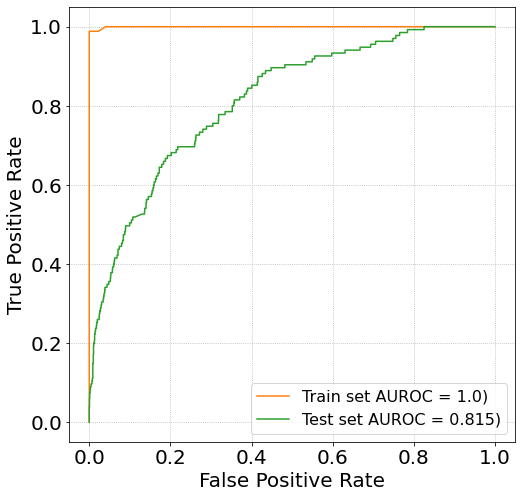

In [96]:
# Graphing results
fpr, tpr, _ = roc_curve(Y_test, Y_test_preds)
auc1 = auc(fpr, tpr)

fpr2, tpr2, _ = roc_curve(Y_train, Y_train_preds)
auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr2, tpr2, color='C1', label="Train set AUROC = "+str(round(auc2, 3))+")")

ax.plot(fpr, tpr, color='C2', label="Test set AUROC = "+str(round(auc1, 3))+")")

ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(linestyle=':')
ax.legend(loc='best', fontsize=16)

plt.show()

In [97]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(Y_test, Y_test_pred)

print(cf_matrix)

#okay, something is wrong here...model just really sucks? I guess fed it 1000 case and 20% split for testing so numbers make sense, just a rare event?


[[1791   16]
 [ 119   16]]


In [99]:
xg_probs = model.predict_proba(X_test)
xg_probs = xg_probs[:, 1]
yhat = model.predict(X_test)
xg_precision, xg_recall, _ = precision_recall_curve(Y_test, xg_probs)
xg_f1, xg_auc = f1_score(Y_test, yhat), auc(xg_recall, xg_precision)

Logistic: f1=0.192 auc=0.338


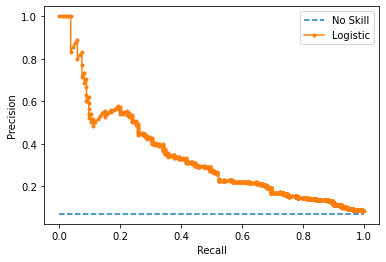

In [100]:
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (xg_f1, xg_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(xg_recall, xg_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()